In [38]:
import matplotlib.pyplot as plt
#Matplotlib is a python library used to create 2D graphs and plots by using python scripts.

import numpy as np
#NumPy is a Python library used for working with arrays.

import PIL
#PIL stands for Python Imaging Library, and it's the original library that enabled Python to deal with images

import tensorflow as tf
#The TensorFlow helps you implement best practices for data automation, model tracking, performance monitoring, and model retraining.

from tensorflow import keras
#Keras is a high-level, deep learning API developed for implementing neural networks

from tensorflow.keras import layers

from tensorflow.keras.models import Sequential

In [39]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [40]:
data_dir =  "/Users/mynampativivekreddy/Desktop/PlantVillage"

In [41]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2153 files belonging to 3 classes.


In [42]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [43]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 2 0 0 2 0 0 1 2 1 0 0]


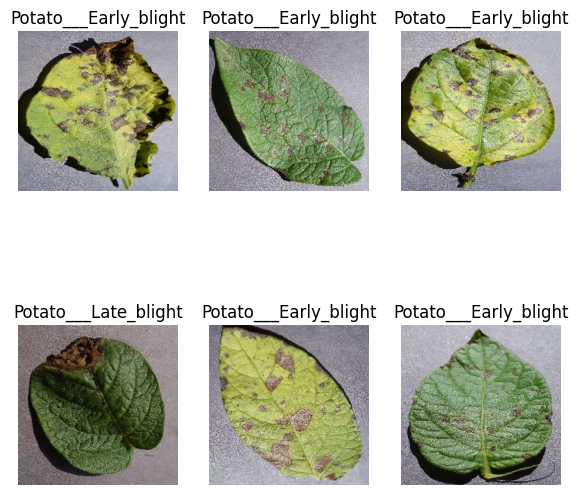

In [7]:
plt.figure(figsize=(7,7))
for image_batch, labels_batch in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2,3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(12)
len(train_ds)

12

In [11]:
test_ds = dataset.skip(12)
len(test_ds)

56

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(1)
len(val_ds)


1

In [14]:
test_ds = test_ds.skip(1)
len(test_ds)

55

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
model_filename = 'model.h5'
model.save(model_filename)

/Users/mynampativivekreddy/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 69s 1s/step - loss: 0.9276 - accuracy: 0.5376 - val_loss: 0.8913 - val_accuracy: 0.8229
Epoch 2/20
54/54 [==============================] - 2141s 40s/step - loss: 0.7194 - accuracy: 0.5422 - val_loss: 0.6136 - val_accuracy: 0.4010
Epoch 3/20
54/54 [==============================] - 84s 2s/step - loss: 0.4313 - accuracy: 0.4433 - val_loss: 0.3433 - val_accuracy: 0.5781
Epoch 4/20
54/54 [==============================] - 190s 4s/step - loss: 0.2128 - accuracy: 0.4456 - val_loss: 0.1773 - val_accuracy: 0.4896
Epoch 5/20
54/54 [==============================] - 64s 1s/step - loss: 0.1509 - accuracy: 0.4479 - val_loss: 0.4613 - val_accuracy: 0.6198
Epoch 6/20
54/54 [==============================] - 64s 1s/step - loss: 0.1500 - accuracy: 0.4531 - val_loss: 0.4386 - val_accuracy: 0.6250
Epoch 7/20
54/54 [==============================] - 70s 1s/step - loss: 0.1075 - accuracy: 0.4473 - val_loss: 0.1153 - val_accuracy: 0.5208
Epoch 8/20
54/54

In [44]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 336ms/step - loss: 0.0932 - accuracy: 0.4727


In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

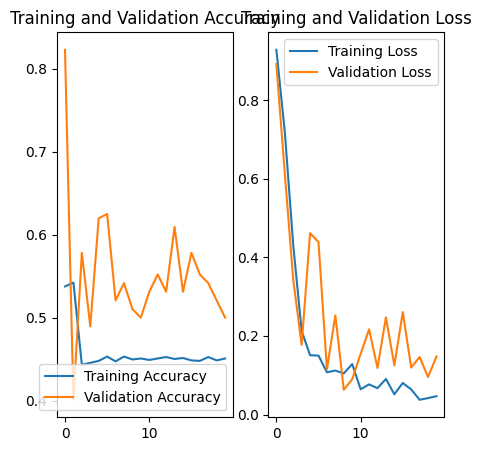

In [46]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 418ms/step
predicted label: Potato___Late_blight


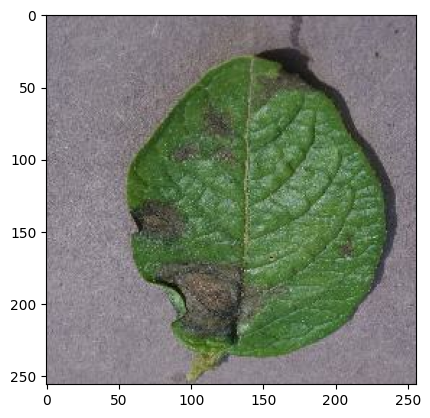

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 30ms/step


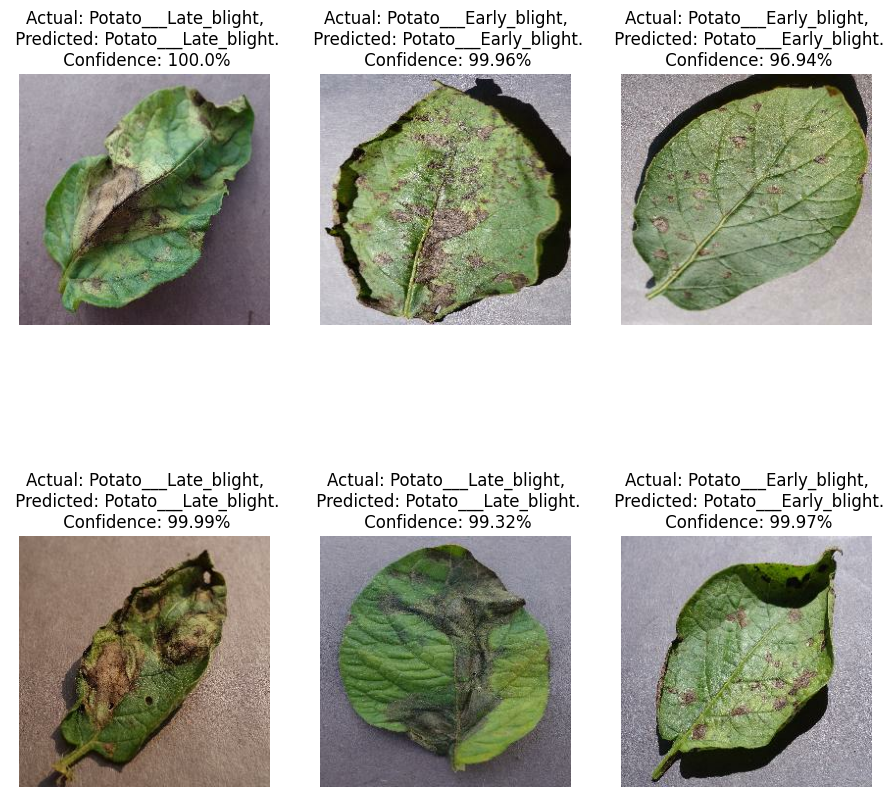

In [49]:
plt.figure(figsize=(11,11))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [50]:
from sklearn.metrics import confusion_matrix


In [51]:
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    true_labels.extend(labels_batch.numpy())
    batch_prediction = model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))


1/1 [==============================] - 0s 331ms/step


In [53]:
cm = confusion_matrix(true_labels, predicted_labels)


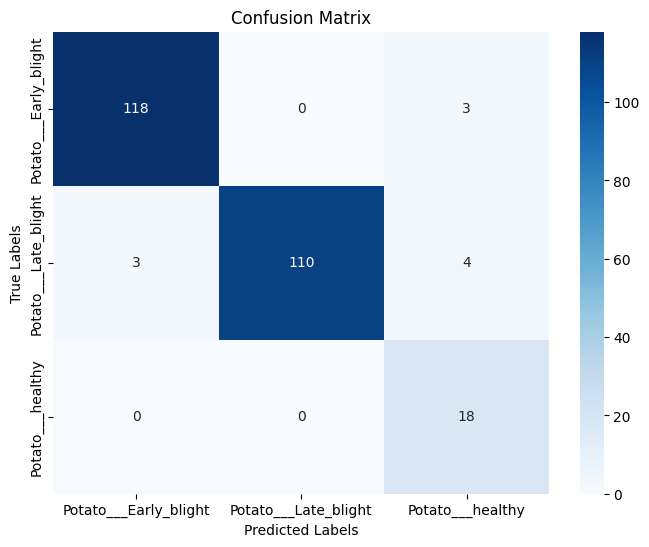

In [54]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [55]:
import tensorflow as tf

# Define the path to the image
sunflower_path = "/Users/mynampativivekreddy/Downloads/healthy.jpg"

# Load the image and resize it to match the model's input size
img_height, img_width = 256, 256
img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))

# Convert the image to an array and expand dimensions to create a batch
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions using the pre-trained model
predictions = model.predict(img_array)

# Get the class names from the dataset
class_names = dataset.class_names

# Convert predictions to softmax score
score = tf.nn.softmax(predictions[0])

# Print the predicted class label and confidence score
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 24ms/step
This image most likely belongs to Potato___healthy with a 57.60 percent confidence.
